In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os



    100% |████████████████████████████████| 993kB 1.9MB/s 


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download_path = os.path.expanduser('~/data')
try:
  os.makedirs(download_path)
except FileExistsError:
  pass

In [0]:
output_file = os.path.join(download_path, 'NSE-TATAGLOBAL11.csv')
train_temp = drive.CreateFile({'id': '1yB6iQMZr7FH7I6qAOFvHKsMN00TrNMda'})
train_temp.GetContentFile(output_file)


In [6]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('/root/data/NSE-TATAGLOBAL11.csv')

#print the head
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


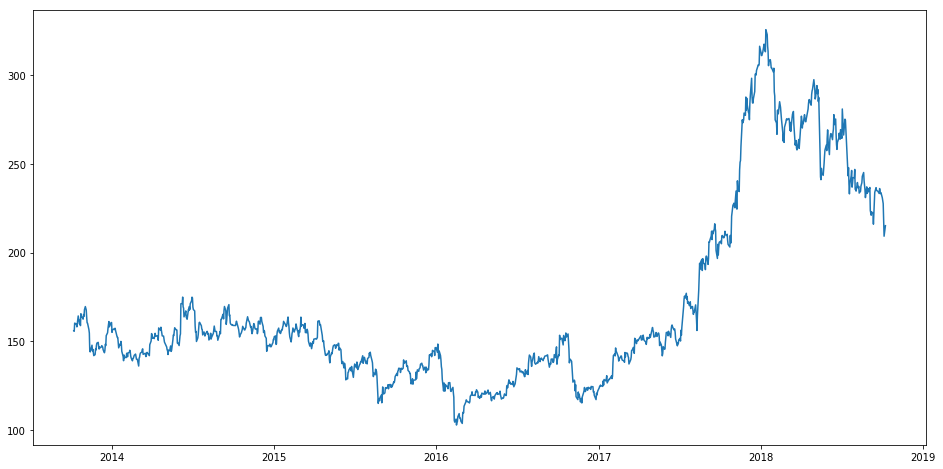

In [7]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')


In [8]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 47s - loss: 0.0011


In [9]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

9.472736843353204

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


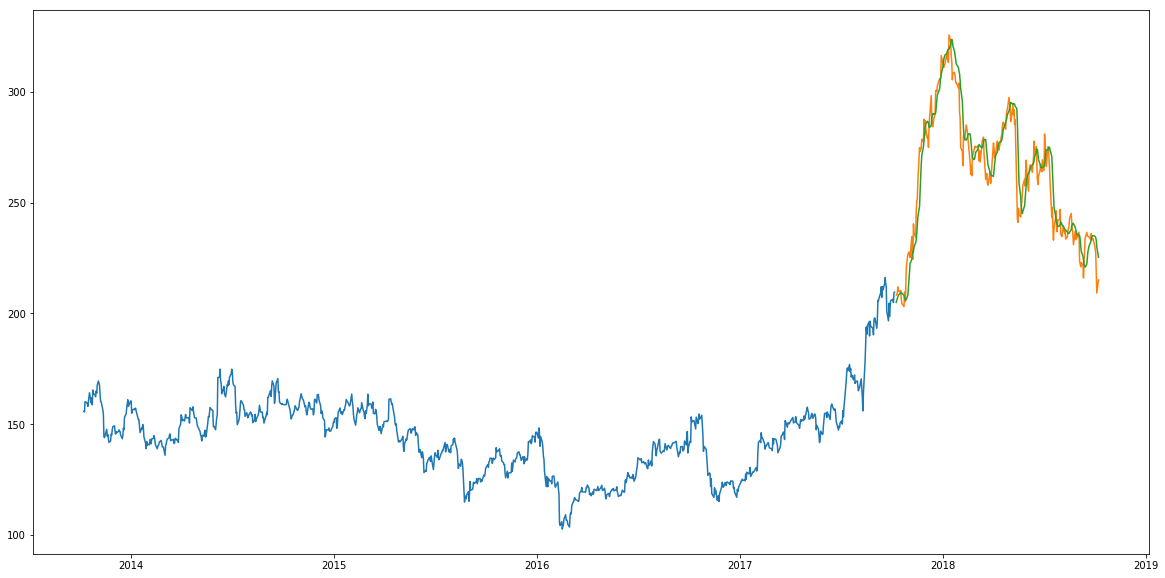

In [10]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])